In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.optimize import root
from scipy.integrate import simps
from scipy.integrate import quad
import pandas as pd
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from multiprocessing import Pool
from functools import partial
from scipy.optimize import curve_fit

In [ ]:
# ------ downsample data -------

def downsample(dataframe, particle_ID, downsample_int):
    temp1 = dataframe[dataframe['test']==particle_ID] # subset data by particle ID
    temp2 = temp1.iloc[::downsample_int, :]  # downsample
    return(temp2)


# ------ distance function --------
def distance(point1, point2):
    dist = np.sqrt((point2[0]-point1[0])**2 + (point2[1]-point1[1])**2)
    return(dist)


# ------- compute MSSI -------

def MSSI(t_idx, s1, s3, data):
    
    s3 = int(s3) # window size (length of sample)
    s1 = int(s1) # granularity (length of segments within sample)
    
    dt = data['t'].iloc[1]-data['t'].iloc[0]
    
    if(s3<s1):
        print('w =', s3 ,'< g =', s1, 'window too small')
        return(None)
    elif(isinstance(s1, int)==False):
        print('g is not an integer')
        return(None)
    elif(isinstance(s3, int)==False):
        print('w is not an integer')
        return(None)

    s2 = int(s3/s1) 
    
    # time reported is centered in the lag
    t = data['t'].iloc[t_idx] + (dt*s3)/2 

    straight_dist = distance([data['X'].iloc[t_idx + s3],data['Y'].iloc[t_idx + s3]],
                            [data['X'].iloc[t_idx],data['Y'].iloc[t_idx]])
    
    total_dist = []
    
    for k in range(0, int(s2)):
        temp = distance([data['X'].iloc[t_idx + (k+1)*s1],data['Y'].iloc[t_idx + (k+1)*s1]],
                            [data['X'].iloc[t_idx + k*s1],data['Y'].iloc[t_idx + k*s1]])
        total_dist = np.append(total_dist,temp)
    total_dist = np.sum(total_dist)
        
    return(t , straight_dist/total_dist)

# loop in paper is s2 -1 but if we use that endpoint for a straight line, 
# it gives incorrect answer (MSSI should return 1)

In [3]:
def get_straight_data(data, granularity, window, path_id):
    
    straight_data_path = []

    times = data[data['test']==0]['t'] # timesteps

    drop = pd.DataFrame({'t':times,'X':data[data['test']==path_id]['X'], 'Y':data[data['test']==path_id]['Y']}) # select path data
    drop = drop[::10]

    #----------COMPUTE STRAIGHTNESS INDEX--------------

    L = len(drop)

    # granularity = 25; 
    # window = 400

    straight_data = np.zeros((int(L-window),2))

    for i in range(0, int(L-window)): # loop through all start times

        # compute MSSI
        temp = np.asarray(MSSI(t_idx = i, s1 = int(granularity), s3 = window, data = drop))

        straight_data[i,:] = temp

    straight_data = pd.DataFrame({'t': straight_data[:,0], 'straight_data': straight_data[:,1]})


    straight_data_path.append(straight_data)
    
    return(straight_data_path)
        
        


In [34]:
num = 15
data = pd.read_csv('All_Paths/ABP_Paths_V6_'+str(num)+'.csv', index_col = 0)

In [35]:
path_ids = data['test'].unique()

In [36]:
%%time

# ---- run in parallel  across all paths-----

worker_num = 4  # how many workers, None means default (max workers)

if __name__ == '__main__':

    inputs = path_ids

    pool = Pool(worker_num) # gathers pool of workers

    result = pool.map(partial(get_straight_data, 
                              data, 
                              25, # granularity
                             400,), # window size
                            inputs) # maps function calls to the workers, by iterating over inputs


CPU times: user 2.24 s, sys: 8.95 s, total: 11.2 s
Wall time: 4min 23s


In [37]:
# put straightness values in array
straight_data_compiled = np.zeros((len(result[0][0]['t']),96))
for i in range(0,96):
    straight_data_compiled[:,i] = result[i][0]['straight_data']
    

# convert to df    
straight_data_compiled = pd.DataFrame(straight_data_compiled, columns = [ np.linspace(0,95,96).astype(int)]) 

# add timestamps back in
straight_data_compiled = straight_data_compiled.assign(t = result[0][0]['t'])

# save as csv
straight_data_compiled.to_csv('Straight_Data/ABP_Straight_Data_V6_'+str(num)+'.csv')
# straight_data_compiled.to_csv('Straight_Data/test.csv')

In [38]:
# look at mssi
straight_data = pd.read_csv(('Straight_Data/ABP_Straight_Data_V6_'+str(num)+'.csv'))
# data_2 = pd.read_csv(('Straight_Data/Straight_Data_V6_5.csv'))

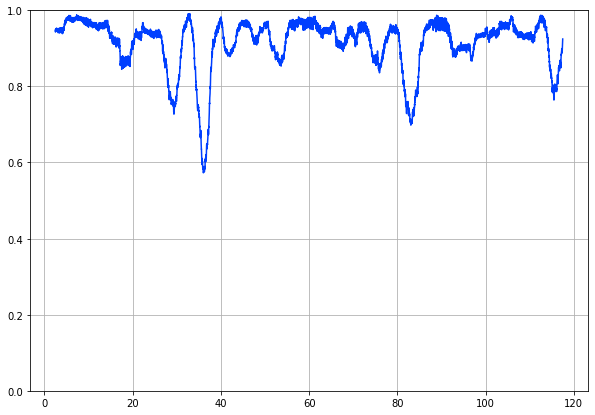

In [39]:
fig, ax = plt.subplots(figsize=(10,7))
data = straight_data
plt.plot(straight_data['t'],straight_data['10']); plt.ylim(0,1)
plt.grid()